IT'S THE
### YOU CAN CALL ME AI
# ADVERSARIAL THROWDOWN


In this notebook, we'll:

* train a neural net on MNIST
* export the trained model (graph *and* weights)
* generate adversarial examples using the Fast Gradient Sign Method (and the targeted variant)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm, tqdm_gui

%matplotlib inline
from IPython.core.pylabtools import figsize

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.5.0'

## Load the dataset

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


## Utility code

In [4]:
def validate_answer(orig, final, thresh=0.1):
    """
    Return True if orig and final are within an RMS threshold
    """
    return np.sqrt(np.mean((orig.reshape(-1)-final.reshape(-1))**2)) <= thresh

In [5]:
def check_answer(logdir, test):
    """
    Check to seee what answer a model gives
    for a data point
    """
    graph = tf.Graph()
    with tf.Session(graph=graph) as sess:
        # Load the saved network
        tf.saved_model.loader.load(sess, ["tag"], logdir)
        # Pull out tensors for the inputs
        x = graph.get_tensor_by_name("x:0")# the ":0" indexes the operation's output tensor
        y_ = graph.get_tensor_by_name("y_:0")
        # Pull out tensors for the logits
        logits = graph.get_tensor_by_name("logits:0")
    
        fd = {x:test.reshape(1,-1)}#, y_:np.array([label])}
        logit_prediction = sess.run(logits, feed_dict=fd)
        
    return logit_prediction.argmax()

In [6]:
class Throwdown(object):
    
    def __init__(self, names, dirs, generators, threshold=0.1):
        self.names = names
        self.dirs = dirs
        self.generators = generators
        self.round = 1
        self.points = [20, 20]
        self.threshold = threshold
        
    def _draw_example(self):
        ind = np.random.choice(np.arange(len(mnist.test.labels)))
        return mnist.test.images[ind,:], mnist.test.labels[ind]
    
    def _plot(self, original, label, adv, labeled):
        plt.figure()
        plt.suptitle("Round %s"%self.round)
        
        plt.subplot(2,3,2)
        plt.imshow(original.reshape((28,28)))
        plt.title("original: class %s"%label)
        plt.axis("off")
        
        plt.subplot(2,3,4)
        plt.imshow(adv[0].reshape((28,28)))
        plt.title("%s\nclassified as: %s\npoints: %s"%(self.names[0], 
                                                       labeled[0], self.points[0]))
        plt.axis("off")
        
        plt.subplot(2,3,6)
        plt.imshow(adv[1].reshape((28,28)))
        plt.title("%s\nclassified as: %s\npoints: %s"%(self.names[1], 
                                                       labeled[1], self.points[1]))
        plt.axis("off")
        
    def _run_round(self):
        # draw an example and label
        ex, label = self._draw_example()
        # generate an adversarial example from each team
        ex0 = self.generators[0](self.dirs[0], ex, label)
        ex1 = self.generators[1](self.dirs[1], ex, label)
        
        # check to see that each example is within the threshold
        check0 = validate_answer(ex, ex0, self.threshold)
        check1 = validate_answer(ex, ex1, self.threshold)
        
        # have team 1's model predict on team 2's example
        # and vice-versa
        if check0:
            pred1 = check_answer(self.dirs[1], ex0)
            if pred1 != label:
                self.points[1] -= 1
        else:
            pred1 = "INVALID"
            
        if check1:
            pred0 = check_answer(self.dirs[0], ex1)
            if pred0 != label:
                self.points[0] -= 1
        else:
            pred0 = "INVALID"
        
        # check to see who won
        
        # do some plottin'
        self._plot(ex, label, [ex0, ex1], [pred0, pred1])
        # the end
        self.round += 1
        
    def throwdoooooown(self):
        while (self.points[0] > 0)&(self.points[1] > 0)&(self.round <= 20):
            self._run_round()
            # in case of a tie
            if (self.points[0] == 0)&(self.points[1] == 0):
                print("IT'S A TIE! ADDING MORE POINTS!")
                self.points=[5,5]
            elif self.points[0] == 0:
                print("%s WINS"%self.names[1])
            elif self.points[1] == 1:
                print("%s WINS"%self.names[0])

## Introduce our contestants

In [7]:
model1 = "logs2/"
model2 = "logs3/"

from offense import generate_adversarial_example as contestant1
from offense import generate_adversarial_example2 as contestant2

team_name_1 = "team foo"
team_name_2 = "team bar"

tf.logging.set_verbosity("WARN")

In [8]:
td = Throwdown(["team 1", "team 2"], [model1, model2], [contestant1, contestant2])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



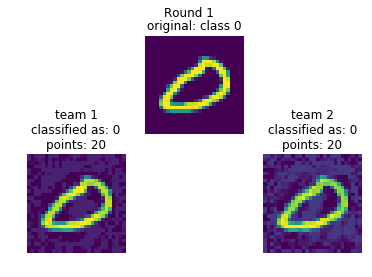

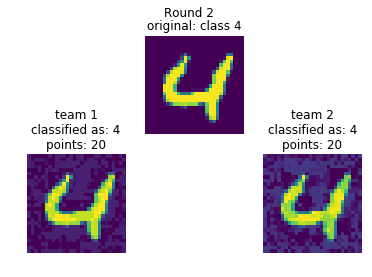

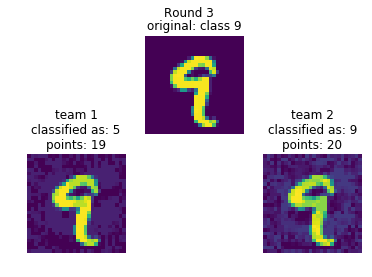

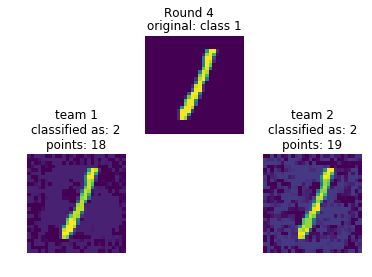

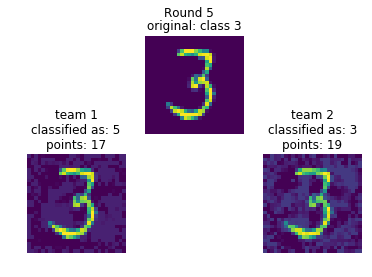

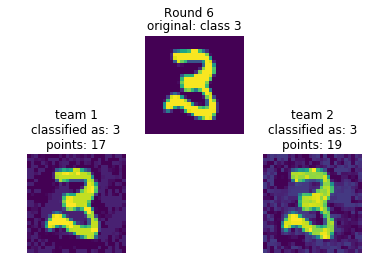

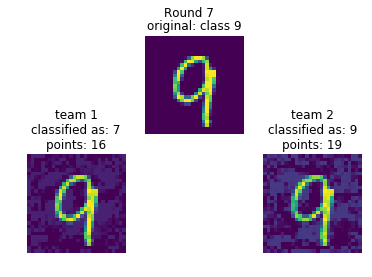

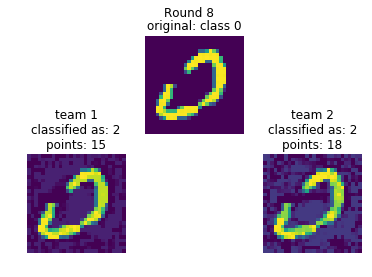

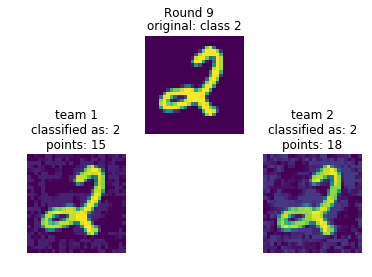

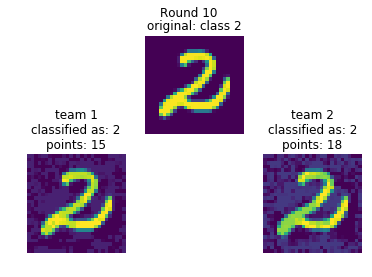

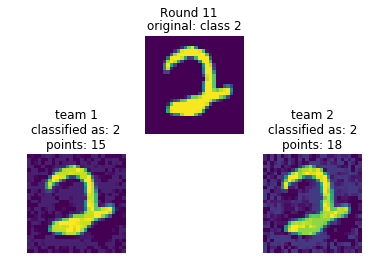

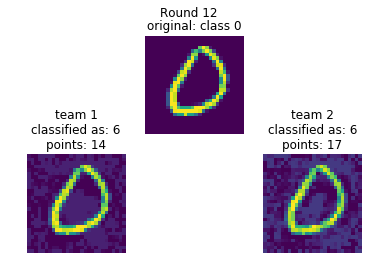

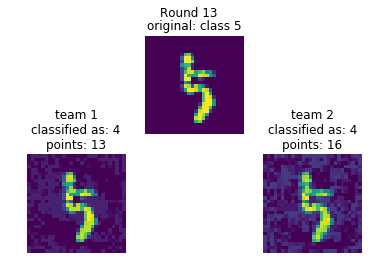

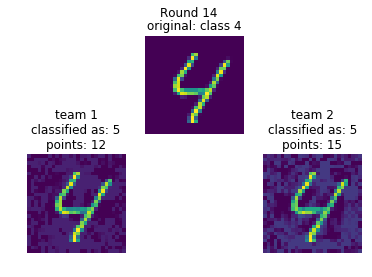

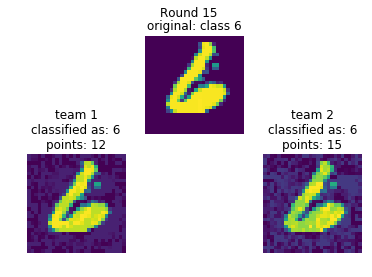

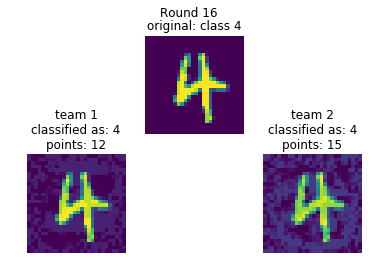

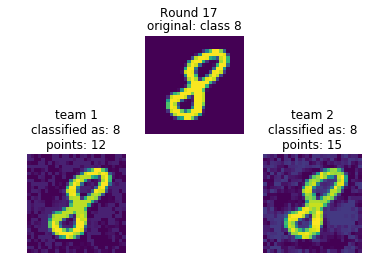

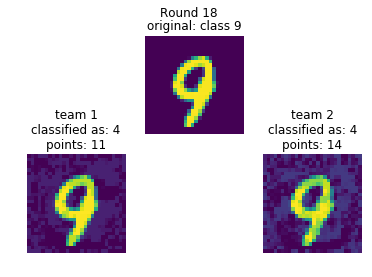

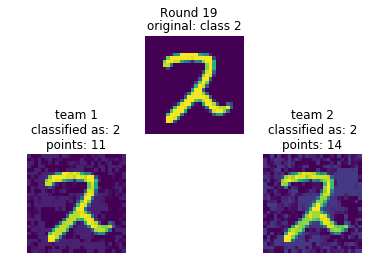

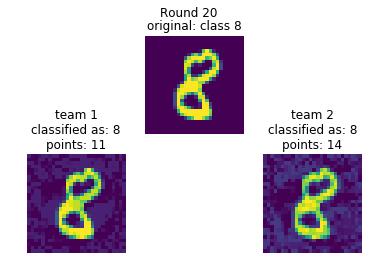

In [9]:
td.throwdoooooown()